In [1]:
import json
import os
from itertools import chain
from sklearn.cluster import KMeans
from scipy.sparse import vstack, save_npz, coo_matrix
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
path = "C:/Users/Dennis Waswa/Desktop/ML1/data/"
reduced_percentage = 0.5
f_name_songlist = "allSongs_reduced.pickle" # name for song list pickle file
f_name_mx = 'sparse_matrix_reduced.npz' # name for sparse matrix
start = time.perf_counter()

In [3]:
#%% Create list of playlists
def pickle_playlists(filename, data_loc, percentage):
    print(os.getcwd())
    db = []
    # get all files (dataset is divided)
    files = os.listdir(data_loc)
    amount_files = len(files)
    limit = int(amount_files * (percentage/100))
    reduced_files = files[:limit]
    for file in reduced_files:
        print(f"getting {file}")
        data = json.load(open(data_loc + file))
        # list of playlist are under the key "playlists"
        for row in data["playlists"]:
            tracks = [song["artist_name"] + " - " + song["track_name"] for song in row["tracks"]]
            db.append(tracks)

    with open(filename, 'wb') as f:
        pickle.dump(db, f, pickle.HIGHEST_PROTOCOL)

if not os.path.isfile(f_name_songlist):
    print("Pickle not found, creating it now. Please wait...")
    pickle_playlists(f_name_songlist, path, reduced_percentage)
    print("Created pickled playlists")
else:
    print("Pickle found :)")

print("Reading Pickle")
with open(f_name_songlist, 'rb') as f:
    playlists = pickle.load(f)
print("Pickle reading finished")

#%% Get vectors for sparse matrix (coordinates in a playlist~songlist where a song is found)
# rows were each playlist. we eliminate rows and remove duplicates to get unique songs
print("Creating vectors for spare matrix")
song_list = list(set(chain(*playlists)))
song_map = {song:i for i,song in enumerate(song_list)}

data_m, row_ix, col_ix = [], [], []

for rowIdx, rw in enumerate(playlists):
    for dbSong in rw:
        row_ix.append(rowIdx)
        col_ix.append(song_map[dbSong])
data_m = [1]*len(col_ix)
print("Finished creating vectors")

#%% Create Sparse Matrix
print("Creating Sparse Matrix")
sparseMatrix = coo_matrix((data_m, (row_ix, col_ix)), shape=(len(playlists), len(song_map)))

save_npz(f_name_mx, sparseMatrix)

#kmeans.labels_
# print time taken
end = time.perf_counter()
print(f"\n\nTOTAL RUN DURATION: {end-start}")

Pickle found :)
Reading Pickle
Pickle reading finished
Creating vectors for spare matrix
Finished creating vectors
Creating Sparse Matrix


TOTAL RUN DURATION: 6.814606400000002


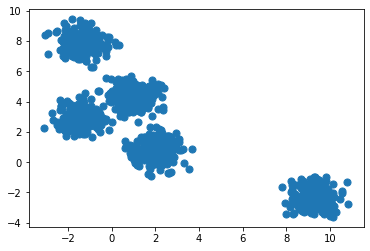

In [6]:
from sklearn.datasets.samples_generator import make_blobs
sparseMatrix, y_true = make_blobs(n_samples=1000, centers=5,
                       cluster_std=0.60, random_state=0)
plt.scatter(sparseMatrix[:, 0], sparseMatrix[:, 1], s=50);

In [7]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
y_means = kmeans.fit(sparseMatrix)
#print(y_means.cluster_centers_)

In [11]:
print(y_means.cluster_centers_)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.23708642e-05 2.23708642e-05 4.47417284e-05 ... 2.23708642e-05
  2.23708642e-05 4.47417284e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [11]:
y_means

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [13]:
y_means = kmeans.predict(sparseMatrix)

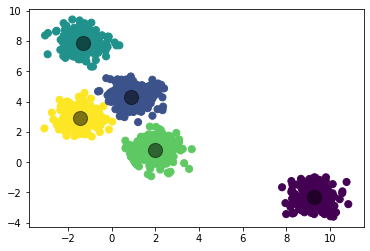

In [15]:
plt.scatter(sparseMatrix[:, 0], sparseMatrix[:, 1], c=y_means, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);